## **Compositional Kernel Search for Gaussian Processes**

Despite its importance, choosing the right covariance kernel to use with a Gaussian Process model can be a difficult task. For example, when modelling long-term historical data, one may be interested in local seasonal effects (short-term periodic parts of the signal), as well as long-term global trends. 

In addition to the commonly chosen kernel functions, the space of possible kernels become very complicated when including *compositional kernels*, such as adding or multiplying two kernels together. For a brief reference on compositional kernels, see [here](https://www.cs.toronto.edu/~duvenaud/cookbook/). 

The `twinlab` library comes with a feature called *Model Selection* which automates the process of kernel selection and composition. This algorithm is a mix of two well-known algorithms: [Compositional Kernel Search](https://arxiv.org/pdf/1302.4922.pdf) and [Scalable Structure Discovery](http://proceedings.mlr.press/v84/kim18a/kim18a.pdf). 

This notebook will cover:
- Compositional Kernel Search in `Campaign`

In [ ]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinlab import
import twinlab as tl

### **Problem Formulation**

Here, we will design a function with multiple components that may be interest for modelling purposes.

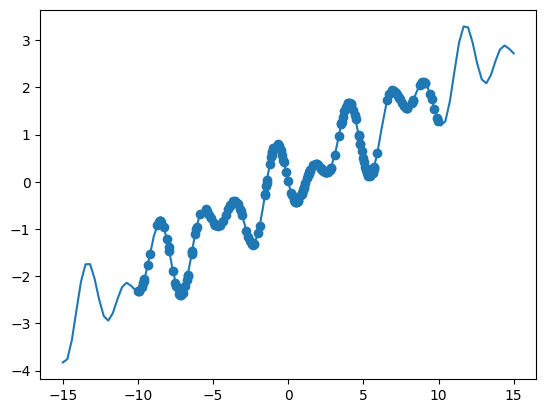

In [2]:
# The true function
def oscillator(x):
    return np.cos((x - 5) / 2) * np.sin(10*x/5) + x * 0.2

X = np.linspace(-15,15,100)[:,np.newaxis]
y = oscillator(X) # Arrange outputs as feature columns

n_data = 200
X_data = np.random.uniform(-10, 10, size=n_data)
y_data = oscillator(X_data)

plt.plot(X,y)
plt.scatter(X_data, y_data)
plt.show()

In [3]:
# Convert to dataframe
df = pd.DataFrame({'x': X_data, 'y': y_data})
df.head()

,x,y
0,-0.316404,0.460369
1,2.519026,0.196517
2,-7.913448,-1.465819
3,7.321803,1.812851
4,-9.648151,-2.148002


In [4]:
# Define the name of the dataset
dataset_id = "ModelSelect_Data"

# Upload the dataset to the cloud
tl.upload_dataset(df, dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset ModelSelect_Data was processed.


### **GP without Model Selection**

For a fair comparison, we will want to run a standard GP with the ubiquitous Matern 5/2 kernel first.

In [5]:
# Initialise campaign
campaign_id = "BasicGP"

campaign_params = {
    "dataset_id": dataset_id,                   # This points the campaign to the uploaded dataset
    "inputs": ["x"],                            # Using the datasets column headers define the input and output data
    "outputs": ["y"],
    "test_train_ratio": 0.75,                   # Determine how much data is used for training, here 75% is used to train the model  
    "estimator": "gaussian_process_regression", # and 25% is used to test it.
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model BasicGP has begun training.


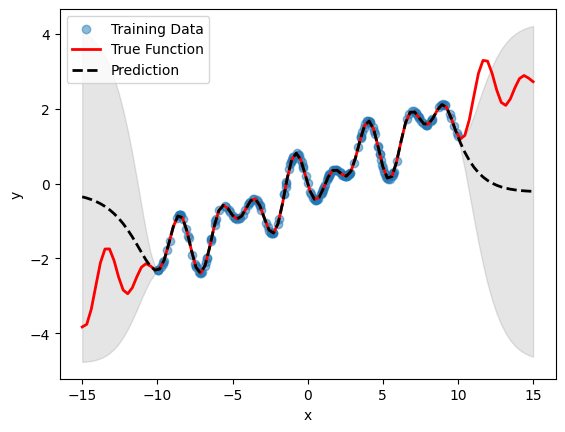

In [6]:
# Plot inference results
df_mean, df_stdev = tl.predict_campaign(pd.DataFrame(X, columns=["x"]), campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

plt.fill_between(X.flatten(), 
                 (y_mean - 1.96*y_stdev).flatten(), 
                 (y_mean + 1.96*y_stdev).flatten(), 
                 color='k', alpha=0.1)

plt.scatter(df['x'], df['y'], alpha=0.5, label='Training Data')
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2, label='True Function')
plt.plot(X, y_mean, c='k', linewidth=2, linestyle='dashed', label='Prediction')
plt.legend()
plt.show()

### **GP with Model Selection**

Model selection in `twinlab` is exposed via the `'model_selection'=True` keyword passed to `tl.train_campaign`. Additional keyword parameters to control the model selection process can be passed to the `'model_selection_kwargs'` dictionary. 

Important keywords include `'depth'`, which controls the maximum number of compositional kernels to search for, and `'beam'`, which controls the number of successful trials carried between search iterations. `'beam'=1` corresponds to greedy search, and `'beam'=None` corresponds to grid search (this is the default, but will result in exponential computational complexity). It is highly recommended to also provide a `'seed'` keyword parameter to allow reproducibility. 

Note that the model achieved by this process is no more *correct* when compared to the basic model (as they are just different ways of describing the same data), however the model with automatic compositional kernel may have better extrapolation properties.

In [7]:
# Initialise campaign
campaign_id = "ModelSelectionGP"

campaign_params = {
    "dataset_id": dataset_id,                   # This points the campaign to the uploaded dataset
    "inputs": ["x"],                            # Using the datasets column headers define the input and output data
    "outputs": ["y"],
    "test_train_ratio": 0.75,                   # Determine how much data is used for training, here 75% is used to train the model  
    "estimator": "gaussian_process_regression", # and 25% is used to test it.
    "model_selection":True,
    "model_selection_kwargs": {
        'depth': 4,
        'beam': 2,
        'seed': 123
    }
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model ModelSelectionGP has begun training.


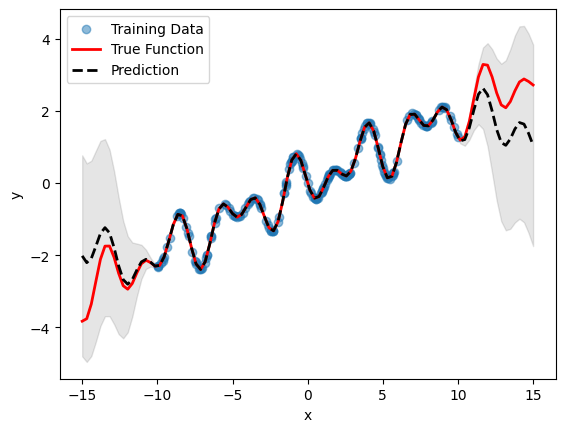

In [8]:
# Plot inference results
df_mean, df_stdev = tl.predict_campaign(pd.DataFrame(X, columns=["x"]), campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

plt.fill_between(X.flatten(), 
                 (y_mean - 1.96*y_stdev).flatten(), 
                 (y_mean + 1.96*y_stdev).flatten(), 
                 color='k', alpha=0.1)

plt.scatter(df['x'], df['y'], alpha=0.5, label='Training Data')
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2, label='True Function')
plt.plot(X, y_mean, c='k', linewidth=2, linestyle='dashed', label='Prediction')
plt.legend()
plt.show()

In [9]:
# Delete campaigns and dataset
tl.delete_campaign("BasicGP")
tl.delete_campaign("ModelSelectionGP")

tl.delete_dataset(dataset_id)